In [1]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import graphviz 

%matplotlib inline

import random
random.seed(123)

## Data Preparation

In [2]:
meta_df_1000 = pd.read_parquet('meta_df_1000_cleaned.parquet')
reviews_df = pd.read_parquet('reviews_df_clean.parquet')

In [3]:
merged_df = pd.merge(meta_df_1000, reviews_df, on='asin', how='inner')
merged_df['category_1'] = merged_df.category.apply(lambda x: x[1])
merged_df['rating'] = merged_df['rating'].astype(float)
merged_df.head()

,category,description,title_x,also_buy,brand,feature,rank,also_view,main_cat,date_x,...,title_y,content,date_y,author,rating,found_helpful,variant,verified_purchase,product,category_1
0,"[Electronics, eBook Readers & Accessories, Rea...",\n,"Thinking Gifts Folding Booklight, Blue, 1 unit...",[],,,"[[Books , 3,563,332]]",[],Books,,...,One Star,didn't work... If I could've given it zero sta...,2018-06-28,Margie,1.0,0,None,True,"Thinking Gifts Folding Booklight, Blue, 1 unit...",eBook Readers & Accessories
1,"[Electronics, eBook Readers & Accessories, Rea...",\n,"Thinking Gifts Folding Booklight, Blue, 1 unit...",[],,,"[[Books , 3,563,332]]",[],Books,,...,Great Bible book light,Gave as a gift to my brother who teaches Sunda...,2017-03-07,Dolphin6411,5.0,0,None,True,"Thinking Gifts Folding Booklight, Blue, 1 unit...",eBook Readers & Accessories
2,"[Electronics, eBook Readers & Accessories, Rea...",\n,"Thinking Gifts Folding Booklight, Blue, 1 unit...",[],,,"[[Books , 3,563,332]]",[],Books,,...,I also love this reading light,I also love this reading light. I've had mine...,2014-08-08,Nancy,5.0,1,None,False,"Thinking Gifts Folding Booklight, Blue, 1 unit...",eBook Readers & Accessories
3,"[Electronics, eBook Readers & Accessories, Rea...",\n,"Thinking Gifts Folding Booklight, Blue, 1 unit...",[],,,"[[Books , 3,563,332]]",[],Books,,...,Great Reading Light,I am buying the second one of these. I used th...,2011-10-24,James G.,5.0,7,None,False,"Thinking Gifts Folding Booklight, Blue, 1 unit...",eBook Readers & Accessories
4,"[Electronics, Accessories & Supplies, Audio & ...",Slim Port Adapter for LG G3 Smartphone! MyDP /...,SlimPort sli44532 Adapter for LG G3 Smartphone...,[],SlimPort,This SlimPort/MyDp adapter is specifically des...,[[Electronics > Accessories & Supplies > Audio...,"[B00HFYLR4M, B015DJ4QYI, 9791688974, B00B2HORK...",Computers,,...,Ease of use,Worked well,2022-10-22,Malcolm W. Collins,4.0,0,Color: Black,True,SlimPort sli44532 Adapter for LG G3 Smartphone...,Accessories & Supplies


In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5921 entries, 0 to 5920
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   category           5921 non-null   object        
 1   description        5921 non-null   object        
 2   title_x            5921 non-null   object        
 3   also_buy           5921 non-null   object        
 4   brand              5921 non-null   object        
 5   feature            5921 non-null   object        
 6   rank               5921 non-null   object        
 7   also_view          5921 non-null   object        
 8   main_cat           5921 non-null   object        
 9   date_x             5921 non-null   object        
 10  price              3066 non-null   float64       
 11  asin               5921 non-null   object        
 12  title_y            5921 non-null   object        
 13  content            5921 non-null   object        
 14  date_y  

In [5]:
merged_df['content'].head(10)

0    didn't work... If I could've given it zero sta...
1    Gave as a gift to my brother who teaches Sunda...
2    I also love this reading light.  I've had mine...
3    I am buying the second one of these. I used th...
4                                          Worked well
5    I had given this item a 1 star and bad review ...
6    I have an LG G3 and love the quality of watchi...
7    Worked perfectly. One side goes into the LG G3...
8    not sure if this adapter is slowing down my ch...
9    The item is a great idea.  I had the same expe...
Name: content, dtype: object

In [6]:
# sampling dataframe to simplify data
# merged_df = merged_df[merged_df['category_1'].isin(list(merged_df['category_1'].value_counts()[:4].index))].groupby('category_1').sample(50)
merged_df = merged_df[merged_df['category_1']\
                    .isin(['Computers & Accessories', 'Camera & Photo', 
                           'Accessories & Supplies', 'Headphones', 'Car & Vehicle Electronics'])]

In [7]:
merged_df['category_1'].value_counts()

Computers & Accessories      2097
Camera & Photo               1413
Accessories & Supplies        901
Headphones                    345
Car & Vehicle Electronics     259
Name: category_1, dtype: int64

In [8]:
nlp = spacy.load('en_core_web_sm')
merged_df['tokens'] = merged_df['content'].apply(lambda x: nlp(x.lower())) 
merged_df.tokens

4                                          (worked, well)
5       (i, had, given, this, item, a, 1, star, and, b...
6       (i, have, an, lg, g3, and, love, the, quality,...
7       (worked, perfectly, ., one, side, goes, into, ...
8       (not, sure, if, this, adapter, is, slowing, do...
                              ...                        
5916    (i, love, this, monitor, !, i, went, through, ...
5917    (i, bought, this, turd, for, my, 2016, macbook...
5918    (i, installed, these, in, my, jeep, ., super, ...
5919    (great, sound, ., my, son, had, them, installe...
5920       (came, as, described, .,  , no, complaints, .)
Name: tokens, Length: 5015, dtype: object

In [9]:
merged_df['tokens'] = merged_df.tokens.apply(lambda x: [w.lemma_ for w in x if not w.is_stop and not w.is_punct and w.lemma_!=' '])

In [10]:
merged_df['tokens'] = merged_df['tokens'].apply(lambda x: ' '.join(x))
merged_df['tokens'].head(10)

4                                                  work
5     give item 1 star bad review not give instructi...
6     lg g3 love quality watch video love transfer l...
7     work perfectly go lg g3 t mobile connect hdmi ...
8     sure adapter slow charger tablet battery drain...
9     item great idea experience device flash work w...
10    work great play movie phone travel sturdy micr...
11    work careful insert completely phone take bit ...
12    packaging description external construction un...
13    say amazon work lg 3smartphone box ship plainl...
Name: tokens, dtype: object

In [11]:
vectorizer = TfidfVectorizer(max_df=0.7)
tokens_vectorized = vectorizer.fit_transform(merged_df['tokens'])
tokens_vectorized

<5015x12814 sparse matrix of type '<class 'numpy.float64'>'
	with 155047 stored elements in Compressed Sparse Row format>

In [12]:
tokens_vectorized.shape

(5015, 12814)

In [63]:
pd.DataFrame(tokens_vectorized.toarray(), columns=vectorizer.get_feature_names_out()).iloc[random.sample(range(X_train.shape[0]), 20), random.sample(range(X_train.shape[1]), 15)]

,headset,spector,bleach,epoxy,hoo,programable,frayed,suprisingly,adhere,hazy,cx995v,650,beginning,radius,boarding
3367,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2410,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2847,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1397,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2726,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
956,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
133,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
756,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
518,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2676,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
pd.DataFrame(tokens_vectorized.toarray(), columns=vectorizer.get_feature_names_out()).sample(500).to_csv('tokens_tfidf_vectorized_sample.csv.csv')


In [13]:
X_train, X_test, y_train, y_test = train_test_split(tokens_vectorized, merged_df['category_1'], test_size=0.2)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4012, 12814), (1003, 12814), (4012,), (1003,))

In [50]:
pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out()).iloc[random.sample(range(X_train.shape[0]), 20), random.sample(range(X_train.shape[1]), 15)]
# y_test.sample(10)

,formatter,mate,disgust,109,armor,barska,share,attain,wndr3700v1,maximum,inward,hotter,supressor,condenser,boston
2543,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1064,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2127,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3245,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2268,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3539,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
488,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2728,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2191,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.20551,0.0,0.0,0.0,0.0,0.0
495,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


In [57]:
pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out()).iloc[random.sample(range(X_test.shape[0]), 20), random.sample(range(X_test.shape[1]), 15)]


,guide,suspicious,notorious,compensate,disintegrate,audio,unroll,tulip,768,tham,periphery,trunk,xagyl,bye,imperceptible
237,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
900,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
642,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
814,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
537,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
509,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
343,0.0,0.0,0.0,0.0,0.0,0.06801,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
322,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
960,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
619,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [16]:
# vectorizer.vocabulary_['ear']
# X_train.shape
# X_train = X_train[:, [i for i in range(X_train.shape[1]) if i != 650]]
feat_names = list(vectorizer.get_feature_names_out())
# feat_names.pop(650)
# feat_names[650]

In [17]:
X_train.shape

(4012, 12814)

In [18]:
dt_clf = DecisionTreeClassifier(criterion='entropy',
                            splitter='best', 
                            max_depth=20, 
                            min_samples_split=8, 
                            min_samples_leaf=4, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight=None,
                            ccp_alpha=0.01)

In [19]:
dt_clf.fit(X_train, y_train)
label_names = [x.replace('&', 'and') for x in dt_clf.classes_]
label_names

['Accessories and Supplies',
 'Camera and Photo',
 'Car and Vehicle Electronics',
 'Computers and Accessories',
 'Headphones']

'dt_text_cat_classification1.pdf'

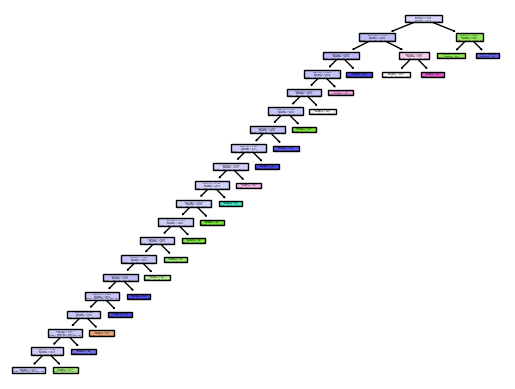

In [20]:

tree.plot_tree(dt_clf, filled=True)
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                      feature_names=feat_names,  
                      class_names=label_names,  
                      filled=True, rounded=True,  
                      special_characters=True)                                    
graph = graphviz.Source(dot_data) 
graph.render('dt_text_cat_classification1') 


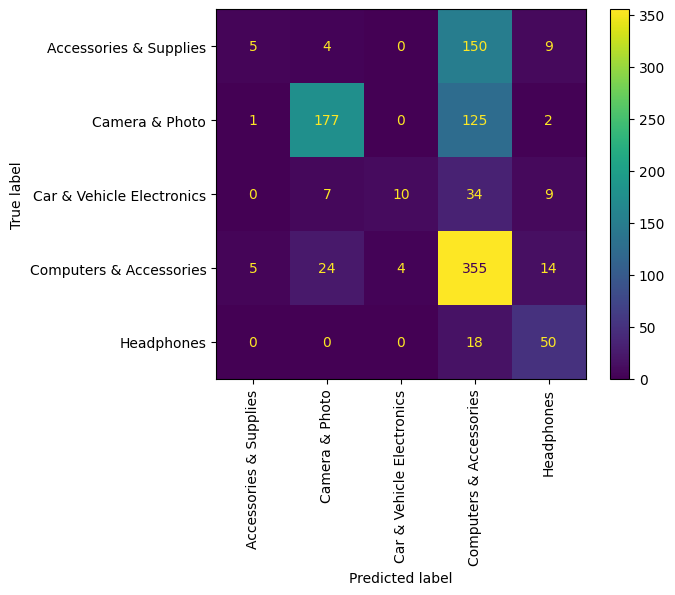

acc 0.5952143569292123
                           precision    recall  f1-score   support

   Accessories & Supplies       0.45      0.03      0.06       168
           Camera & Photo       0.83      0.58      0.68       305
Car & Vehicle Electronics       0.71      0.17      0.27        60
  Computers & Accessories       0.52      0.88      0.65       402
               Headphones       0.60      0.74      0.66        68

                 accuracy                           0.60      1003
                macro avg       0.62      0.48      0.46      1003
             weighted avg       0.62      0.60      0.54      1003



In [69]:
y_pred = dt_clf.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=dt_clf.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

'dt_text_cat_classification2.pdf'

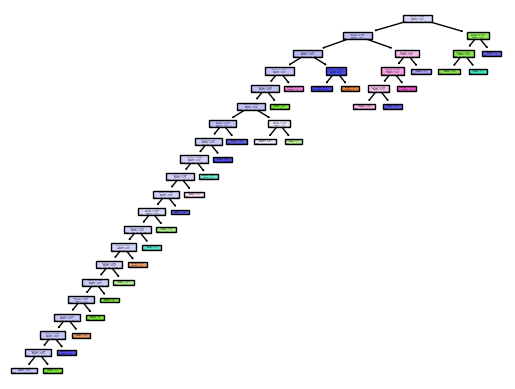

In [71]:
dt_clf = DecisionTreeClassifier(criterion='entropy',
                            splitter='best',  
                            max_depth=20, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight=None,
                            ccp_alpha=0.005)

dt_clf.fit(X_train, y_train)
label_names = [x.replace('&', 'and') for x in dt_clf.classes_]
# label_names


tree.plot_tree(dt_clf, filled=True)
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                      feature_names=feat_names,  
                      class_names=label_names,  
                      filled=True, rounded=True,  
                      special_characters=True)                                    
graph = graphviz.Source(dot_data) 
graph.render('dt_text_cat_classification2') 


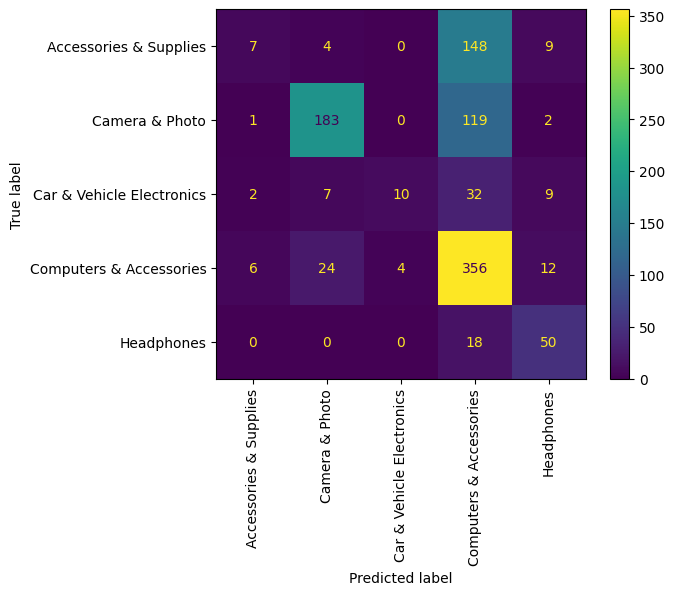

acc 0.6041874376869392
                           precision    recall  f1-score   support

   Accessories & Supplies       0.44      0.04      0.08       168
           Camera & Photo       0.84      0.60      0.70       305
Car & Vehicle Electronics       0.71      0.17      0.27        60
  Computers & Accessories       0.53      0.89      0.66       402
               Headphones       0.61      0.74      0.67        68

                 accuracy                           0.60      1003
                macro avg       0.63      0.49      0.48      1003
             weighted avg       0.62      0.60      0.55      1003



In [72]:
y_pred = dt_clf.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=dt_clf.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

'dt_text_cat_classification3.pdf'

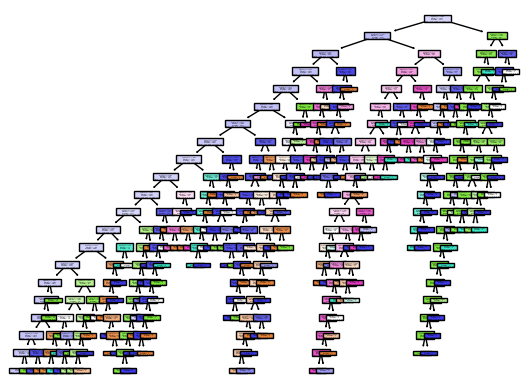

In [85]:
dt_clf = DecisionTreeClassifier(criterion='entropy', 
                            splitter='best', 
                            max_depth=20, 
                            min_samples_split=8, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight=None,
                            ccp_alpha=0.001)

dt_clf.fit(X_train, y_train)
label_names = [x.replace('&', 'and') for x in dt_clf.classes_]
# label_names


tree.plot_tree(dt_clf, filled=True)
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                      feature_names=feat_names,  
                      class_names=label_names,  
                      filled=True, rounded=True,  
                      special_characters=True)                                    
graph = graphviz.Source(dot_data) 
graph.render('dt_text_cat_classification3') 


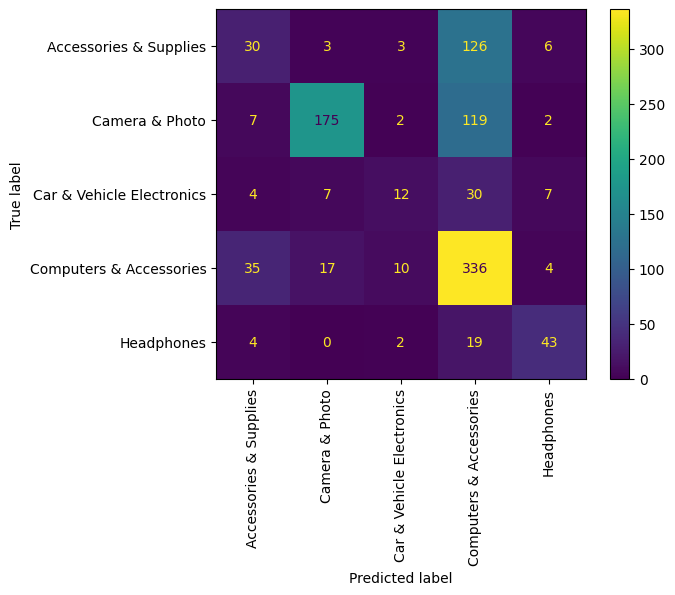

acc 0.5942173479561316
                           precision    recall  f1-score   support

   Accessories & Supplies       0.38      0.18      0.24       168
           Camera & Photo       0.87      0.57      0.69       305
Car & Vehicle Electronics       0.41      0.20      0.27        60
  Computers & Accessories       0.53      0.84      0.65       402
               Headphones       0.69      0.63      0.66        68

                 accuracy                           0.59      1003
                macro avg       0.58      0.48      0.50      1003
             weighted avg       0.61      0.59      0.57      1003



In [86]:
y_pred = dt_clf.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=dt_clf.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

'dt_text_cat_classification4.pdf'

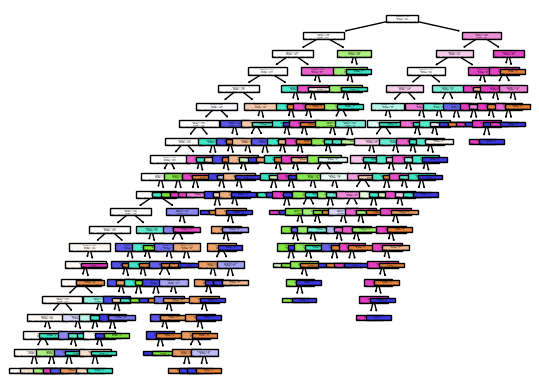

In [87]:
dt_clf = DecisionTreeClassifier(criterion='entropy',
                            splitter='best',
                            max_depth=20, 
                            min_samples_split=8, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight='balanced',
                            ccp_alpha=0.001)

dt_clf.fit(X_train, y_train)
label_names = [x.replace('&', 'and') for x in dt_clf.classes_]
# label_names


tree.plot_tree(dt_clf, filled=True)
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                      feature_names=feat_names,  
                      class_names=label_names,  
                      filled=True, rounded=True,  
                      special_characters=True)                                    
graph = graphviz.Source(dot_data) 
graph.render('dt_text_cat_classification4') 


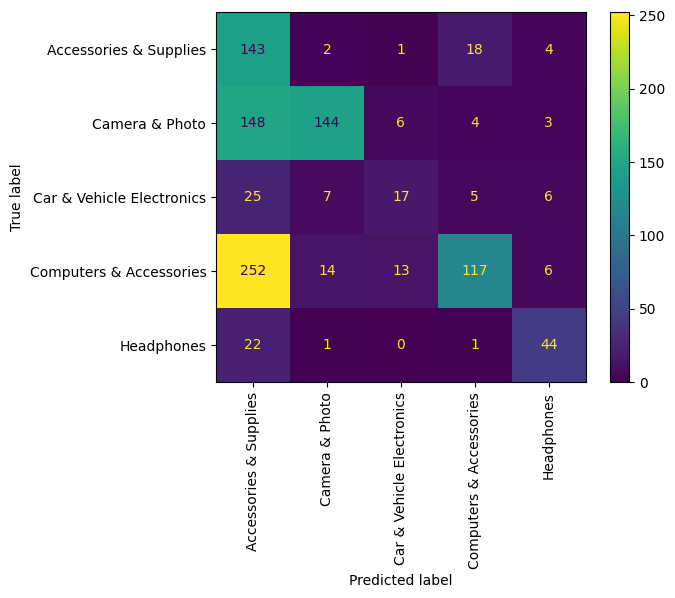

acc 0.46360917248255235
                           precision    recall  f1-score   support

   Accessories & Supplies       0.24      0.85      0.38       168
           Camera & Photo       0.86      0.47      0.61       305
Car & Vehicle Electronics       0.46      0.28      0.35        60
  Computers & Accessories       0.81      0.29      0.43       402
               Headphones       0.70      0.65      0.67        68

                 accuracy                           0.46      1003
                macro avg       0.61      0.51      0.49      1003
             weighted avg       0.70      0.46      0.49      1003



In [88]:
y_pred = dt_clf.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=dt_clf.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

'dt_text_cat_classification.pdf'

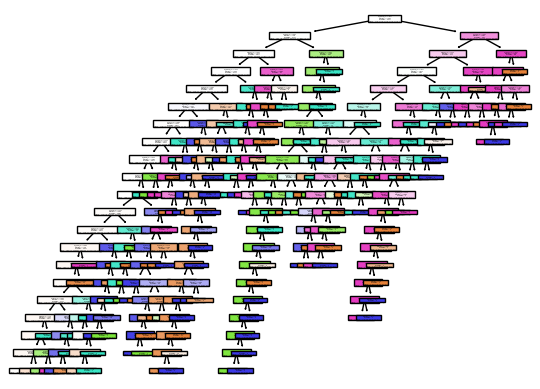

In [34]:
dt_clf = DecisionTreeClassifier(criterion='entropy',
                            splitter='best',
                            max_depth=20, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight='balanced',
                            ccp_alpha=0.001)

dt_clf.fit(X_train, y_train)
label_names = [x.replace('&', 'and') for x in dt_clf.classes_]
# label_names


tree.plot_tree(dt_clf, filled=True)
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                      feature_names=feat_names,  
                      class_names=label_names,  
                      filled=True, rounded=True,  
                      special_characters=True)                                    
graph = graphviz.Source(dot_data) 
graph.render('dt_text_cat_classification') 


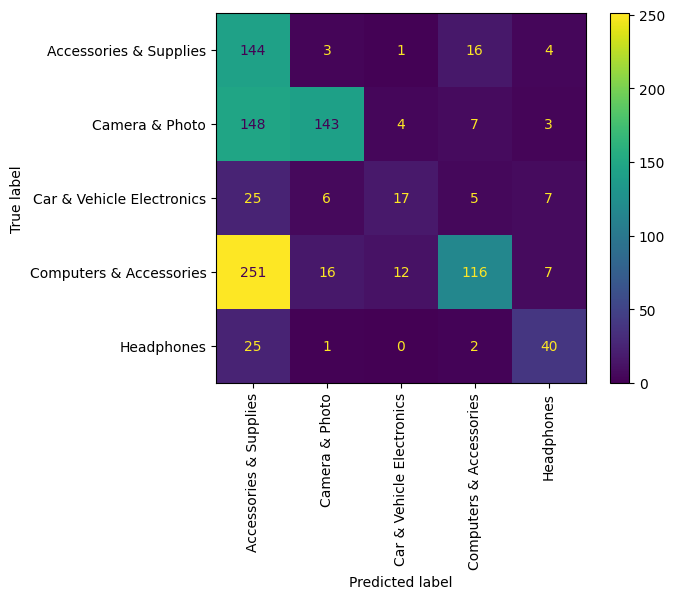

acc 0.45862412761714855
                           precision    recall  f1-score   support

   Accessories & Supplies       0.24      0.86      0.38       168
           Camera & Photo       0.85      0.47      0.60       305
Car & Vehicle Electronics       0.50      0.28      0.36        60
  Computers & Accessories       0.79      0.29      0.42       402
               Headphones       0.66      0.59      0.62        68

                 accuracy                           0.46      1003
                macro avg       0.61      0.50      0.48      1003
             weighted avg       0.69      0.46      0.48      1003



In [35]:
y_pred = dt_clf.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=dt_clf.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [21]:
n_classes = np.unique(y_train).shape[0]
# np.hstack(np.atleast_2d(np.unique(y_train, return_counts=True)))
np.atleast_2d(np.unique(y_train, return_counts=True)).T
# np.unique(y_train).shape[0]
display({l: np.power(y_train.shape[0], 1)/(n_classes * np.power(cnt, 1)) \
                                          for l, cnt in np.atleast_2d(np.unique(y_train, return_counts=True)).T})

display({l: np.power(y_train.shape[0], 0.7)/(n_classes * np.power(cnt, 0.7)) \
                                          for l, cnt in np.atleast_2d(np.unique(y_train, return_counts=True)).T})

display(np.unique(y_train, return_counts=True))

{'Accessories & Supplies': 1.1144444444444443,
 'Camera & Photo': 0.7183527305282006,
 'Car & Vehicle Electronics': 3.7849056603773583,
 'Computers & Accessories': 0.47535545023696685,
 'Headphones': 2.917818181818182}

{'Accessories & Supplies': 0.6656560678403207,
 'Camera & Photo': 0.4894918007411691,
 'Car & Vehicle Electronics': 1.566561828222244,
 'Computers & Accessories': 0.3666248793798699,
 'Headphones': 1.3057191000821484}

(array(['Accessories & Supplies', 'Camera & Photo',
        'Car & Vehicle Electronics', 'Computers & Accessories',
        'Headphones'], dtype=object),
 array([ 720, 1117,  212, 1688,  275]))

'dt_text_cat_classification.pdf'

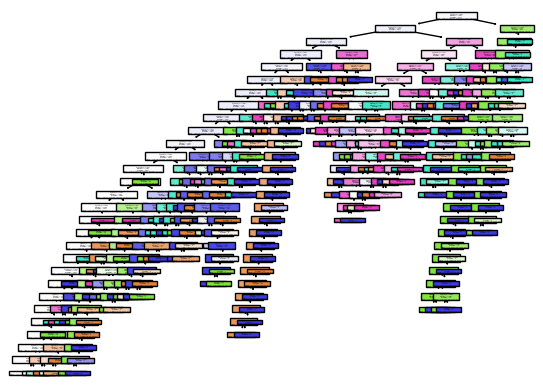

In [22]:
n_classes = np.unique(y_train).shape[0]
dt_clf = DecisionTreeClassifier(criterion='entropy',
                            splitter='best',
                            max_depth=28, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight={l: np.power(y_train.shape[0], 0.72)/(n_classes * np.power(cnt, 0.72)) \
                                          for l, cnt in np.atleast_2d(np.unique(y_train, return_counts=True)).T},
                            ccp_alpha=0.001)

dt_clf.fit(X_train, y_train)
label_names = [x.replace('&', 'and') for x in dt_clf.classes_]
# label_names


tree.plot_tree(dt_clf, filled=True)
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                      feature_names=feat_names,  
                      class_names=label_names,  
                      filled=True, rounded=True,  
                      special_characters=True)                                    
graph = graphviz.Source(dot_data) 
graph.render('dt_text_cat_classification5') 


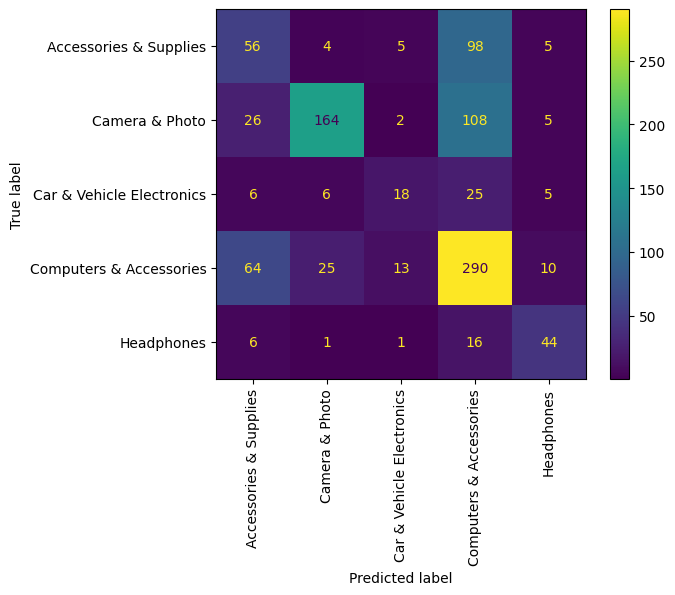

acc 0.5702891326021934
                           precision    recall  f1-score   support

   Accessories & Supplies       0.35      0.33      0.34       168
           Camera & Photo       0.82      0.54      0.65       305
Car & Vehicle Electronics       0.46      0.30      0.36        60
  Computers & Accessories       0.54      0.72      0.62       402
               Headphones       0.64      0.65      0.64        68

                 accuracy                           0.57      1003
                macro avg       0.56      0.51      0.52      1003
             weighted avg       0.60      0.57      0.57      1003



In [63]:
y_pred = dt_clf.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=dt_clf.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))